Before starting, let's import some RooFit stuff.

In [1]:
from ROOT import RooGaussian
from ROOT import RooExponential
from ROOT import RooProdPdf
from ROOT import RooExtendPdf
from ROOT import RooFit
from ROOT import RooRealVar
from ROOT import RooAddPdf
from ROOT import RooArgList
from ROOT import RooArgSet
import ROOT

def destruct_object(object_):
    """Destruct an object inheriting from TObject.

    See http://root.cern.ch/download/doc/ROOTUsersGuideHTML/ch19.html#d5e27551
    for more details

    provided by @apuignav

    :param object_: object to delete
    :type object_: TObject

    """
    if issubclass(type(object_), ROOT.TObject):
        object_.IsA().Destructor(object_)

Welcome to JupyROOT 6.08/06


Now the variables and models are defined. A Gaussian in invariant mass for the signal, an exponential for background; a BDT which is flat between 0 and 1 for the signal, and falls off exponentially for the background.

In [2]:
bdt      = RooRealVar("BDT","some awesome BDT",0.,1.)
mass     = RooRealVar("mass","invariant mass",5100.,5300,"MeV/c^{2}")
sy_start = 100.
by_start = 900.
sy_min = 0.
by_min = 0.
sy_max = 100000.
by_max = 100000.
sigyield = RooRealVar("sigyield","signal yield",sy_start,sy_min,sy_max)
bkgyield = RooRealVar("bkgyield","background yield",by_start,by_min,by_max)
bmassPDF = RooGaussian("bmass","B mass shape",mass,RooFit.RooConst(5200.),RooFit.RooConst(20.))
bkgmPDF  = RooExponential("bkgmass","bkg mass shape",mass,RooFit.RooConst(-1./200.))
bdtsPDF  = RooExponential("bdts","sig bdt shape",bdt,RooFit.RooConst(0.))
bdtbPDF  = RooExponential("bdtb","bkg bdt shape",bdt,RooFit.RooConst(-3.))
sigPDF   = RooProdPdf("sigpdf","signal pdf",bmassPDF,bdtsPDF)
bkgPDF   = RooProdPdf("bkgpdf","background pdf",bkgmPDF,bdtbPDF)
EsigPDF  = RooExtendPdf("Esigpdf","extended signal pdf",sigPDF,sigyield)
EbkgPDF  = RooExtendPdf("Ebkgpdf","extended background pdf",bkgPDF,bkgyield)
combPDF  = RooAddPdf("fullpdf","full pdf",RooArgList(EsigPDF,EbkgPDF))
EmsigPDF = RooExtendPdf("Emsigpdf","extended signal mass pdf",bmassPDF,sigyield)
EmbkgPDF = RooExtendPdf("Embkgpdf","extended background mass pdf",bkgmPDF,bkgyield)
combmPDF = RooAddPdf("fullmasspdf","full mass pdf",RooArgList(EmsigPDF,EmbkgPDF))

Lets look at a small toy where a cut on the BDT cleans up the invariant mass spectrum.

[#1] INFO:Plotting -- RooAbsReal::plotOn(Esigpdf) plot on mass integrates over variables (BDT)
[#1] INFO:Plotting -- RooAbsReal::plotOn(Ebkgpdf) plot on mass integrates over variables (BDT)
[#1] INFO:Plotting -- RooAbsReal::plotOn(Esigpdf) plot on BDT integrates over variables (mass)
[#1] INFO:Plotting -- RooAbsReal::plotOn(Ebkgpdf) plot on BDT integrates over variables (mass)
[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 2165 will supercede previous event count of 10000 for normalization of PDF projections


Info in <TCanvas::Print>: png file mass.png has been created
Info in <TCanvas::Print>: png file bdt.png has been created
Info in <TCanvas::Print>: png file cut.png has been created


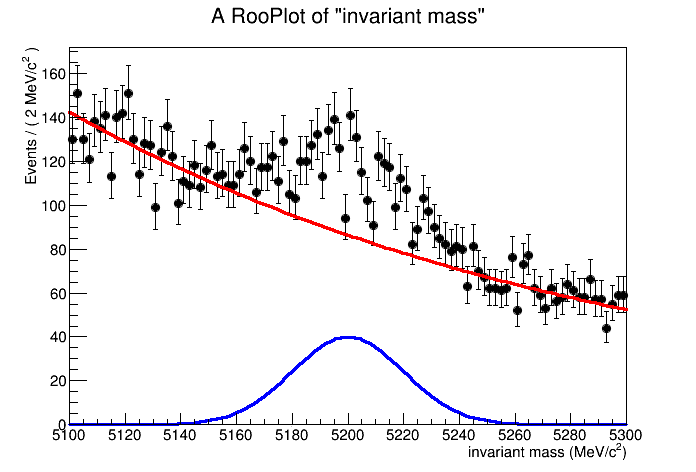

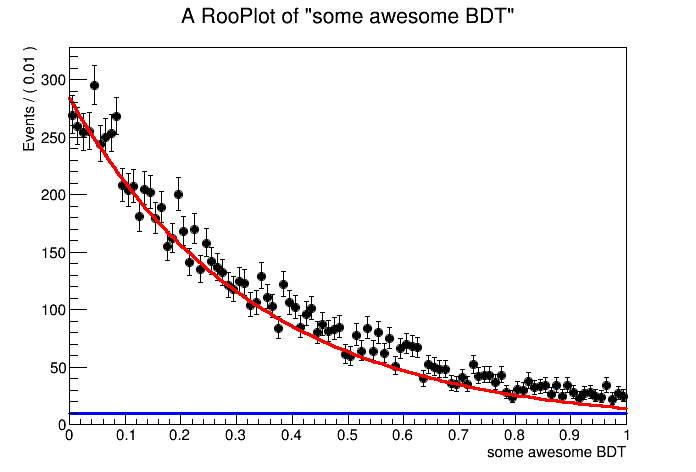

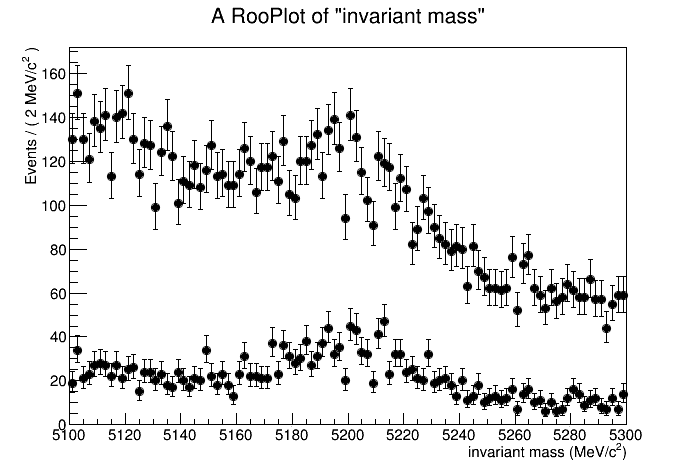

In [3]:
SIMEVTS = 10000#0
NTOYS = 1000
truesigyield = SIMEVTS*(sigyield.getVal()/(sigyield.getVal()+bkgyield.getVal()))
def gentoy():
    toydata = combPDF.generate(RooArgSet(bdt,mass),SIMEVTS)
    return toydata
toydata = gentoy()
from ROOT import TCanvas, RooCmdArg
from ROOT.RooFit import Cut
c = TCanvas()
frame = mass.frame()
toydata.plotOn(frame)
#smalldata = toydata.reduce(Cut("BDT>0.5"))
#smalldata.plotOn(frame)#,Cut("BDT>0.5"))
EsigPDF.plotOn(frame,RooFit.LineColor(ROOT.kBlue),RooFit.LineColor(ROOT.kBlue),RooFit.Normalization(truesigyield/SIMEVTS))
EbkgPDF.plotOn(frame,RooFit.LineColor(ROOT.kBlue),RooFit.LineColor(ROOT.kRed),RooFit.Normalization(1.-truesigyield/SIMEVTS))
frame.Draw()
c.Draw()
c.SaveAs("mass.png")
c2 = TCanvas()
frame2 = bdt.frame()
toydata.plotOn(frame2)
#combPDF.plotOn(frame2,RooFit.Components(EsigPDF))
#combPDF.plotOn(frame2,RooFit.Components("EbkgPDF"))
#EbkgPDF.plotOn(frame2,RooFit.LineColor(ROOT.kRed))
EsigPDF.plotOn(frame2,RooFit.LineColor(ROOT.kBlue),RooFit.LineColor(ROOT.kBlue),RooFit.Normalization(truesigyield/SIMEVTS))
EbkgPDF.plotOn(frame2,RooFit.LineColor(ROOT.kBlue),RooFit.LineColor(ROOT.kRed),RooFit.Normalization(1.-truesigyield/SIMEVTS))
frame2.Draw()
c2.Draw()
c2.SaveAs("bdt.png")
c3 = TCanvas()
frame = mass.frame()
toydata.plotOn(frame)
smalldata = toydata.reduce(Cut("BDT>0.5"))
smalldata.plotOn(frame)#,Cut("BDT>0.5"))
frame.Draw()
c3.Draw()
c3.SaveAs("cut.png")
destruct_object(toydata)
destruct_object(smalldata)

For automisation, a few helper functions: resetting fit parameters, fitting the toy data (with possible cut on the BDT - the efficiency for the signal as function of cut value is perfectly known, as well as the true signal expected yield), determination of pull in yield and bias.

For each toy, a scan over BDT cut values is performed (in steps of 0.1) to pick the best cut value (this is the one with the smallest uncertainty on the signal yield before cut).

In [6]:
from ROOT import RooMsgService
def reset():
    bkgyield.setMin(by_min)
    bkgyield.setMin(by_min)
    bkgyield.setMax(by_max)
    bkgyield.setMax(by_max)
    bkgyield.setVal(by_start)
    sigyield.setMin(sy_min)
    sigyield.setMin(sy_min)
    sigyield.setMax(sy_max)
    sigyield.setMax(sy_max)
    sigyield.setVal(sy_start)

def fitwithcut(dataset,cutvalue,verbose=False):
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    #fitres = combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(2))
    fitres = combmPDF.fitTo(smalldata,RooFit.Save(verbose),RooFit.NumCPU(2),RooFit.PrintLevel(-1000))
    if verbose:
        fitres.Print("V")
    destruct_object(smalldata)
    val, err = sigyield.getVal(),sigyield.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se
                            

def runtoy(verbose=False):
    reset()
    toydata = gentoy()
    RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)
    cutval = 0.0
    sy,se = fitwithcut(toydata,cutval)
    
    res = sy-truesigyield
    pull = res/se
    
    cutval = 0.5
    sy2,se2 = fitwithcut(toydata,cutval,verbose)
    res2 = sy2-truesigyield
    pull2 = res2/se2
    
    by,be = sy,se
    for tv in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        y,e = fitwithcut(toydata,tv)
        if e/y < be/by:
            by,be = y,e
    resbest = by-truesigyield
    pullbest = resbest/be
    destruct_object(toydata)
    
    return res,pull,res2,pull2, resbest,pullbest

runtoy(True) #just a test

(-51.542131039632636,
 -0.6715174387412102,
 -59.97989318963141,
 -0.7940994150271867,
 -12.746601269319285,
 -0.17454428856631152)

--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x4cc74f0
  Clients: 
  Servers: 
    (0x4cc3bd0,V-) RooExtendPdf::Emsigpdf "extended signal mass pdf"
    (0x4ccd690,V-) RooExtendPdf::Embkgpdf "extended background mass pdf"
  Proxies: 
    !refCoefNorm -> 
    !pdfs -> 
      1)  Emsigpdf
      2)  Embkgpdf
    !coefficients -> 
--- RooAbsReal ---

  Plot label is "fullmasspdf"
--- RooAbsPdf ---
Cached value = 0

  RooFitResult: minimized FCN value: -2974.41, estimated distance to minimum: 1.01093e-09
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
              bkgyield    9.0000e+02    1.6280e+03 +/-  5.08e+01  <none>
              sigyield    1.0000e+02    4.7001e+02 +/-  3.78e+01  <none>



Now, run many toys, record the pulls and residuals for "no cut", "cut at 0.5", and "best cut".

In [5]:
from ROOT import TH1F, RooRandom
pullhist = TH1F("pullhist","pulls without BDT cut",100,-10,10)
pull2hist = TH1F("pull2hist","pulls with BDT cut",100,-10,10)
pullbhist = TH1F("pullbhist","pulls with best BDT cut",100,-10,10)
reshist = TH1F("reshist","residuals without BDT cut",300,-800,800)
res2hist = TH1F("res2hist","residuals with BDT cut",300,-800,800)
resbhist = TH1F("resbhist","residuals with best BDT cut",300,-800,800)
for i in xrange(NTOYS):
    print ".",
    RooRandom.randomGenerator().SetSeed(i)
    res,pull,res2,pull2,resb,pullb = runtoy()
    pullhist.Fill(pull)
    pull2hist.Fill(pull2)
    pullbhist.Fill(pullb)
    reshist.Fill(res)
    res2hist.Fill(res2)
    resbhist.Fill(resb)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Info in <TCanvas::Print>: png file yieldpulls.png has been created


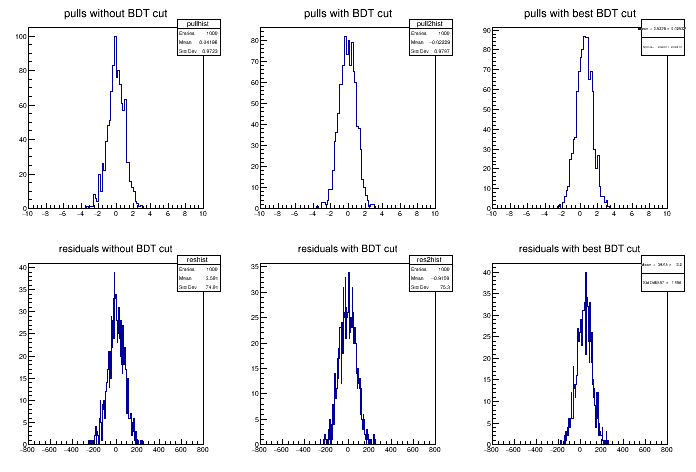

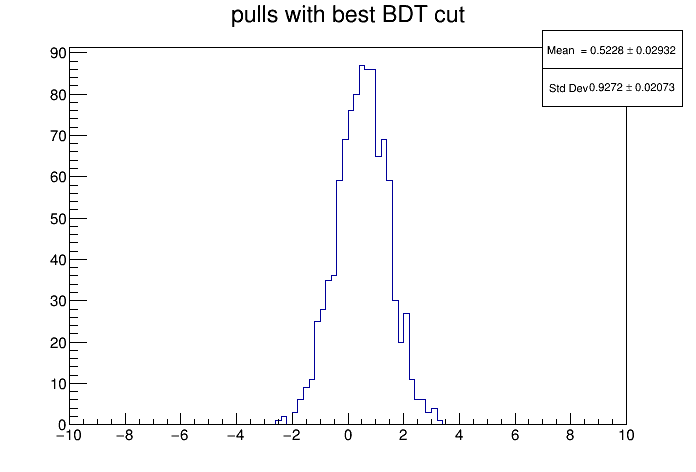

In [15]:
cc = TCanvas()
cc.Divide(3,2)
cc.cd(1)
pullhist.Draw()
cc.cd(2)
pull2hist.Draw()
cc.cd(3)
pullbhist.Draw()
cc.cd(4)
reshist.Draw()
cc.cd(5)
res2hist.Draw()
cc.cd(6)
resbhist.Draw()
cc.Draw()

ccc = TCanvas()
pullbhist.Draw()
ROOT.gStyle.SetOptStat(2200)
ccc.Draw()
ccc.SaveAs("yieldpulls.png")

Let's have a look. The scenario "no cut" and the scenario with the fixed cut seem unbiased. But when always picking the best cut value, on seems to be off by 10 σ!

In [7]:
print "resolution without cut is        ", reshist.GetRMS()
print "bias without cut is              ", pullhist.GetMean(), u"±", pullhist.GetMeanError()
print "resolution with cut at 0.5 is    ", res2hist.GetRMS()
print "bias with cut at 0.5 is          ", pull2hist.GetMean(), u"±", pull2hist.GetMeanError()
print "resolution with optimised cut is ", resbhist.GetRMS()
print "bias with optimised cut is       ", pullbhist.GetMean(), u"±", pullbhist.GetMeanError()


resolution without cut is         74.9057159179
bias without cut is               0.0419591830542 ± 0.0307453294568
resolution with cut at 0.5 is     75.2958825903
bias with cut at 0.5 is           -0.0222874142525 ± 0.0309797427696
resolution with optimised cut is  69.5709855636
bias with optimised cut is        0.522803769643 ± 0.0293201205415
